# Pierwszy program

Budujemy pusty obwód kwantowy złożony z jednoqubitowego rejestru kwantowego i jednobitowego rejestru klasycznego.

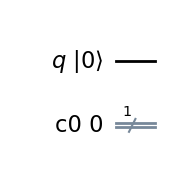

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
# Create quantum and 1 qubit register
qreg_q = QuantumRegister(1, 'q')
# Create classical 1 bit register
creg_c0 = ClassicalRegister(1, 'c0')
# Compose registers into a quantum circuit
circuit0 = QuantumCircuit(qreg_q, creg_c0)
# Postać grficzna obwodu. Domyślnie początkowe wartości rejestrów są ustawione na |0> i 0.
circuit0.draw('mpl', initial_state=True)

Wiele informacji na temat stanu rejestru można uzyskać za pomocą modułu `QunatumInfo`.

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


<IPython.core.display.Latex object>

[1. 0.]
{np.str_('0'): np.int64(1000)}


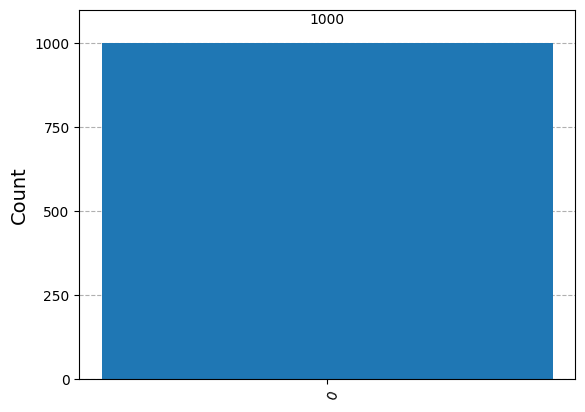

In [104]:
import qiskit.quantum_info as qinf
from qiskit.visualization import plot_histogram

psi0 = qinf.Statevector(circuit0)

print(psi0)
display(psi0.draw('latex', prefix='\\ket{\\psi_0} = '))
print(psi0.probabilities())
counts = psi0.sample_counts(shots=1000)
print(counts)
display(plot_histogram(counts))


Zbudujmy trzy obwody, każdy złożony z jednej bramki kwantowej.

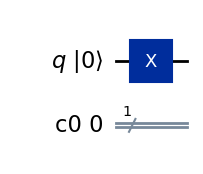

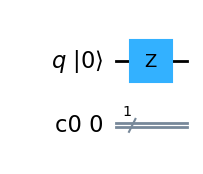

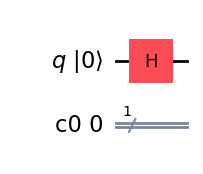

In [105]:
circuit1 = circuit0.copy()
circuit1.x(0)
display(circuit1.draw('mpl', initial_state=True))
circuit2 = circuit0.copy()
circuit2.z(0)
display(circuit2.draw('mpl', initial_state=True))
circuit3 = circuit0.copy()
circuit3.h(0)
display(circuit3.draw('mpl', initial_state=True))

Stan końcowy rejestru ma postać

In [106]:
psi1 = qinf.Statevector(circuit1)
psi1_l = psi1.draw('latex', prefix='\\ket{\\psi_1} = ')
psi2 = qinf.Statevector(circuit2)
psi2_l = psi2.draw('latex', prefix='\\ket{\\psi_2} = ')
psi3 = qinf.Statevector(circuit3)
psi3_l = psi3.draw('latex', prefix='\\ket{\\psi_3} = ')
display(psi1_l)
display(psi2_l)
display(psi3_l)




<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Wykonując prosty eksperyment kwantowy uzyskujemy statystykę wyników pomiarów.

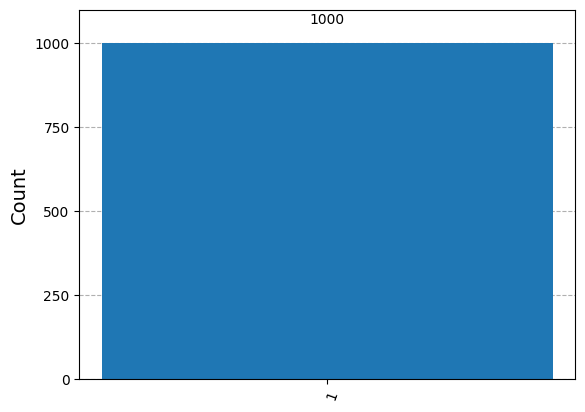

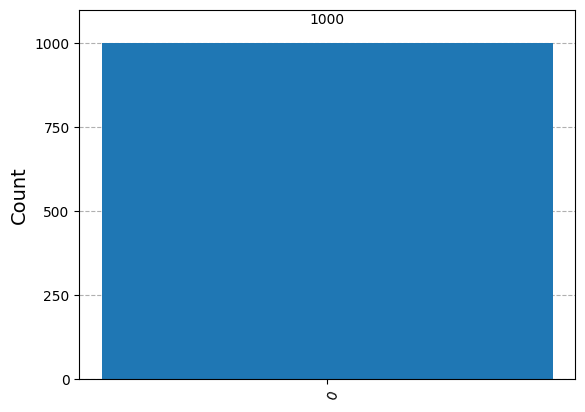

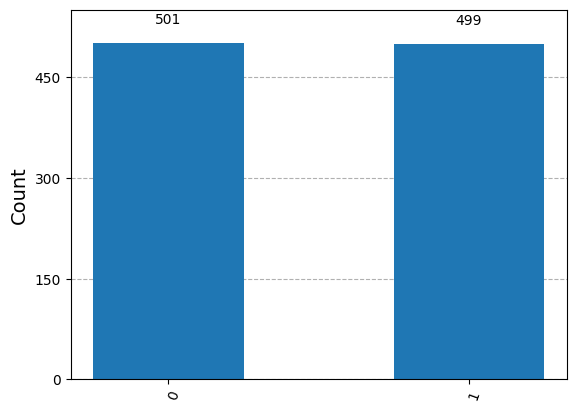

In [107]:
cnt_1= psi1.sample_counts(shots=1000)
cnt_2= psi2.sample_counts(shots=1000)
cnt_3= psi3.sample_counts(shots=1000)
display(plot_histogram(cnt_1)) 
display(plot_histogram(cnt_2)) 
display(plot_histogram(cnt_3))

PrimitiveResult([SamplerPubResult(data=DataBin(c0=BitArray(<shape=(), num_shots=1000, num_bits=1>)), metadata={'shots': 1000, 'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c0=BitArray(<shape=(), num_shots=1000, num_bits=1>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})
{'0': 1000}
{'0': 1000}


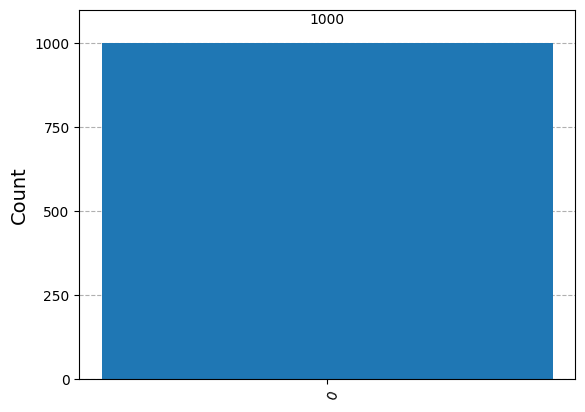

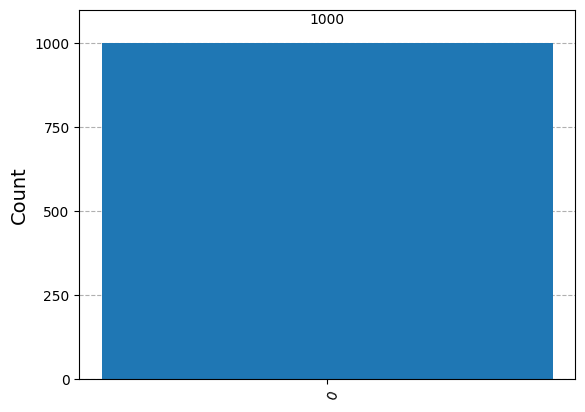

In [108]:
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler()
job_sampler=sampler.run([circuit2,circuit3], shots=1000)
result = job_sampler.result()
print(result)
counts2 = result[0].data.c0.get_counts()
counts3 = result[1].data.c0.get_counts()
print(counts2)
print(counts3)
display(plot_histogram(counts2),plot_histogram(counts3))


## Uruchomienie programu/obwodu

Istnieją dwa podstawowe schematy (tzw. prymitywy) komunikacji z QPU:
- `Sampler` zwraca wynik w postaci statystyki wyników pomiarów
- `Estimator` zwraca wynik w postaci wartości oczekiwanej zadanej obserwabli.

Prymityw `Sampler` wymaga, aby analizowany obwód kwantowy **kończył** się pomiarem stanu rejestrów kwantowych. 

Prymityw `Estimator` wymaga, aby analizowany obwód kwantowy **nie kończył** się pomiarem. 


W przykładzie wykorzystamy `Sampler`, dlatego dodamy pomiar końcowy do naszego obwodu

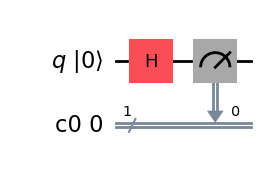

In [109]:
circuit3_sampled = circuit3.copy()
circuit3_sampled.measure(0,0)
display(circuit3_sampled.draw('mpl', initial_state=True))

Przed uruchumieniem, niezależnie od docelowej platformy, należy dokonać translacji abstrakcyjnego obwodu na zestaw bramek wspieranych na danej platformie. Proces ten nazywa się **transpilacją**. 

In [110]:
from qiskit import transpile

### Uruchomienie w symulatorze

`Qiskit Aer` jest symulatorem komputera kwantowego zapewniającym interfejs identyczny z `IBM Runtime`, czyli tym, który służy do uruchamiania programów na rzeczywistym QPU. 

In [111]:
from qiskit_aer import AerSimulator

Teraz inicjujemy platformę wykonawczą. Po jej inicjalizacji możemy dokonać transpilacji obwodu. Jak zobaczymy `Qiskit Aer` natywnie pracuje na bramkach wysokiego poziomu, więc wynik transpilacji jest identyczny z obwodem wejściowym.

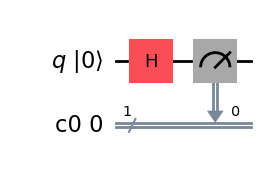

In [112]:
backend_aer = AerSimulator() # you can pass noise model here
circuit3_transpiled = transpile(circuit3_sampled, backend=backend_aer)
display(circuit3_transpiled.draw('mpl', initial_state=True))

Teraz można przystąpić do symulacji. Inicjujemy metodę komunikacji z symulatorem.

In [113]:
from qiskit_aer.primitives import SamplerV2 as AerSampler
sampler_aer = AerSampler()

Uruchamiamy zadanie symulacji. Obwód kwantowy jest uruchamiany `shots` razy.

In [114]:
job_aer=sampler_aer.run([circuit3_transpiled], shots=1000)

Wyniki eksperymentu są przechowywane w zmiennej `job`. Za jej pomocą można uzyskać do nich dostęp

In [115]:
result_aer=job_aer.result()

i dokonać ich prezentacji

**Uwaga!** Zwróć uwagę na sposób pobrania wyników symulacji - w poniższym kodzie `c0` to nazwa rejestru klasycznego. Gdy rejestr klasyczny zmieni nazwę, to zmieni się również instrukcja pobierająca dane.

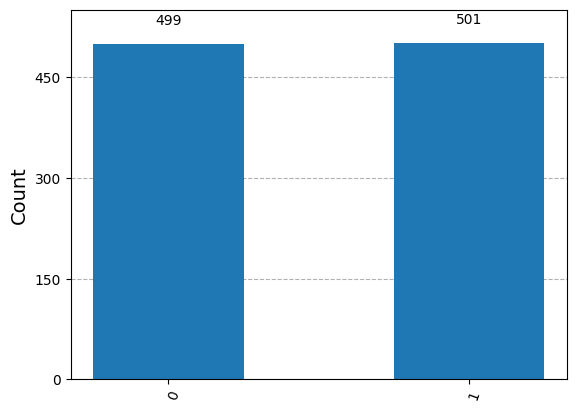

In [116]:
counts_aer = result_aer[0].data.c0.get_counts()
plot_histogram(counts_aer)

### Uruchomienie programu na QPU

Schemat prowadzenia obliczeń jest taki sam jak na symulatorze. Rożnica polega na uzupełnieniu go komunikacją z usługą `IBM Runtime`

Znajdź najmniej obciążony i dostępny komputer kwantowy.

In [117]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
backend_qpu = service.least_busy(simulator=False, operational=True)
print(backend_qpu.name, " num qubits:", backend_qpu.configuration().n_qubits)

ibm_kyiv  num qubits: 127


Dokonaj transpilacji obwodu stosownie do właściwości wybranej platformy sprzętowej. Tym razem wynik transpilacji będzie istotnie różnił się od obwodu w postaci ogólnej. Rozmiar wynikowego rejestru kwantowego będzie równy liczbie qubitów komputera. Opcja `idle_wires` pozwala na ukrycie nieużywanych qubitów.

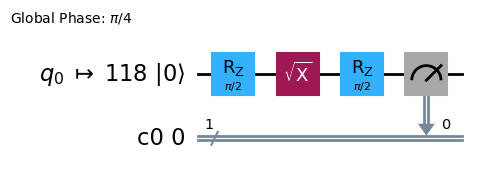

In [118]:
circuit3_qpu = transpile(circuit3_sampled, backend=backend_qpu)
circuit3_qpu.draw('mpl', initial_state=True, idle_wires=False)

Zainicjuj prymityw `SamplerV2` z `IBM Runtime`

In [119]:
from qiskit_ibm_runtime import SamplerV2 as QPUSampler
sampler_qpu = QPUSampler(backend_qpu)

Teraz można uruchomić obwód na rzeczywistym komputerze kwantowym. Zadanie jest wstawiane do kolejki zadań i oczekuje na wolne zasoby.

**Uwaga!** Czas oczekiwania może być bardzo różny i zajmować od pojedynczych sekund do wielu godzin.

In [120]:
job_qpu = sampler_qpu.run([circuit3_qpu])
print(job_qpu)

<RuntimeJobV2('cz7t9wfb7tt0008fsx3g', 'sampler')>


Status wykonania zadania można sprawdzić korzystając ze zwróconej zmiennej, 

In [ ]:
job_qpu.status()

'QUEUED'

albo w terminie poźniejszym korzystając z ID zadania na stronie [`Dashboard`](https://quantum.ibm.com/)

In [123]:
job_gpu = service.job('cz7t9wfb7tt0008fsx3g')
job_qpu.status()

'DONE'

Odbiór i prezentacja wyników odbywa się tak samo jak dla symulatora.

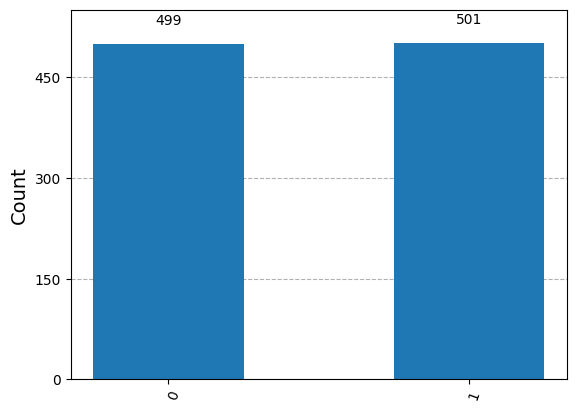

In [124]:
result_qpu=job_qpu.result()
counts_qpu = result_qpu[0].data.c0.get_counts()
plot_histogram(counts_aer)